#  <center> "Inter- and intra-annual calculation of snow cover from NDSI (Normalised Difference Snow Cover Index) using Sentinel-2 and Geemap"</center>
## Final project for the course "Retrieval of biophysical parameters from optical and radar data" 
### Student: Tomás V. San Miguel
### Date: February 2024.
### [Link Github](https://github.com/tomasvsm/snowcover_sentinels)

## <center> Workflow </center>
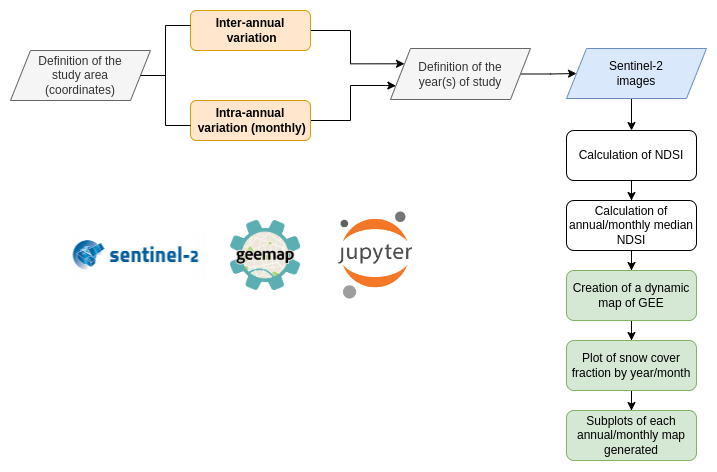

This code allows us to easily calculate the snow cover (with an NDSI threshold of 0.4, a binary map is generated where 0=no snow, 1=snow) in an area by providing the coordinates of the area of interest, it is possible to calculate annual medians in the case of inter-annual variation, or monthly medians in the case of intra-annual variation. All this is done using Geemap, a Python package for interactive geospatial analysis and visualisation using Google Earth Engine.


In terms of visualisation, both inter- and intra-annual variation, a dynamic map was incorporated to visualise the layers as a whole, a linear graph to see the variation of the snow cover fraction and finally the representation in sub-plots of each of the maps generated.

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import os
import numpy as np
import requests
from PIL import Image
from io import BytesIO  # Import BytesIO module
import math
from datetime import datetime
import calendar
from matplotlib import gridspec

In [2]:
#authentication in gee
ee.Authenticate()
ee.Initialize()

## <center> Define the study area </center>

In [3]:
# Define the new region of interest (ROI)

#Example of a study area in Argentina.
studyarea_coords = [
    [-73.08291795032227,-49.73893844720413],
    [-73.10763718860352,-50.02211372384004],
    [-72.78628709094727,-50.02387834814054],
    [-72.79452683704102,-49.72651159599671],
    [-73.08291795032227,-49.73893844720413]
]

studyarea = ee.Geometry.Polygon(studyarea_coords)

# Get the area of the polygon
area = studyarea.area().getInfo()

# Print results
print(f'Polygon area: {area} square meters')

Polygon area: 704699127.5213771 square meters


# <center> Inter-annual variation of NDSI </center>

In [4]:
# Create a sequence of the years that want to be evaluated
years_eval = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [5]:
# Function to get the NDSI median for each year
def year_ndsi(year):
    # Create start and end dates for each entry of the years_eval list
    date_start = ee.Date.fromYMD(year, 1, 1)
    date_end = ee.Date.fromYMD(year + 1, 1, 1)

    # Filter Sentinel-2 image collection according to dates, study area, and select bands
    dataset = (ee.ImageCollection('COPERNICUS/S2')
               .filter(ee.Filter.date(date_start, date_end))
               .filterBounds(studyarea)
               .select(['B3', 'B11']))  # Selecting Green (B3) and SWIR (B11) bands for NDSI calculation

    # Calculate NDSI for each image in the collection
    def calculate_ndsi(image):
        ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
        return image.addBands(ndsi)

    # Map the NDSI calculation function over the image collection
    ndsi_images = dataset.map(calculate_ndsi)

    # Calculate median NDSI
    median = ndsi_images.median()

    # Clip image to study area
    image_clip = median.clip(studyarea)
    # Add the start year property to each image
    image_clip = image_clip.set('startYear', year)

    # Return image
    return ee.Image(image_clip)

In [6]:
# Map the function to all the entries in the years_eval list
result = list(map(year_ndsi, years_eval))
# Create an image collection from the list of images generated in the last step
result = ee.ImageCollection.fromImages(result)

In [7]:
# Create a Map
Map = geemap.Map(basemap='HYBRID')

# Snow cover data for each year
snow_cover_data = {}

# Iterate over each year
for year in years_eval:
    # Get the image for the current year
    image = result.filter(ee.Filter.eq('startYear', year)).first()

    # Add Snow Map layer to the map
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    snow_map = ndsi.where(ndsi.lte(0.4), 0).where(ndsi.gt(0.4), 1).rename('snowMap').cast({'snowMap': 'uint8'})
    Map.addLayer(snow_map, {'min': 0, 'max': 1, 'palette': ['#000000', '#ffffff']}, f'SnowMap_{year}')
    
    # Calculate snow cover fraction
    snow_cover_fraction = snow_map.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=1000, # Adjust scale for both visualization and region reduction
        maxPixels=1e9, # Set maxPixels to a high value
        bestEffort=True
    ).get('snowMap').getInfo()

    # Print information
    print(f'Year: {year}')
    print(f'Snow Cover Fraction: {snow_cover_fraction}\n')

    # Store the result in the dictionary
    snow_cover_data[year] = {
        'snow_cover_fraction': snow_cover_fraction
    }

# Center the map on the study area
Map.centerObject(studyarea, 9)

# Display the map
Map

Year: 2016
Snow Cover Fraction: 0.20080480738276651

Year: 2017
Snow Cover Fraction: 0.4862395822155456

Year: 2018
Snow Cover Fraction: 0.3827771220087995

Year: 2019
Snow Cover Fraction: 0.27633508602496715

Year: 2020
Snow Cover Fraction: 0.29291054118825366

Year: 2021
Snow Cover Fraction: 0.21873233894910055

Year: 2022
Snow Cover Fraction: 0.07205708767035095

Year: 2023
Snow Cover Fraction: 0.13004971921164654



Map(center=[-49.880441648717714, -72.9416050522184], controls=(WidgetControl(options=['position', 'transparent…

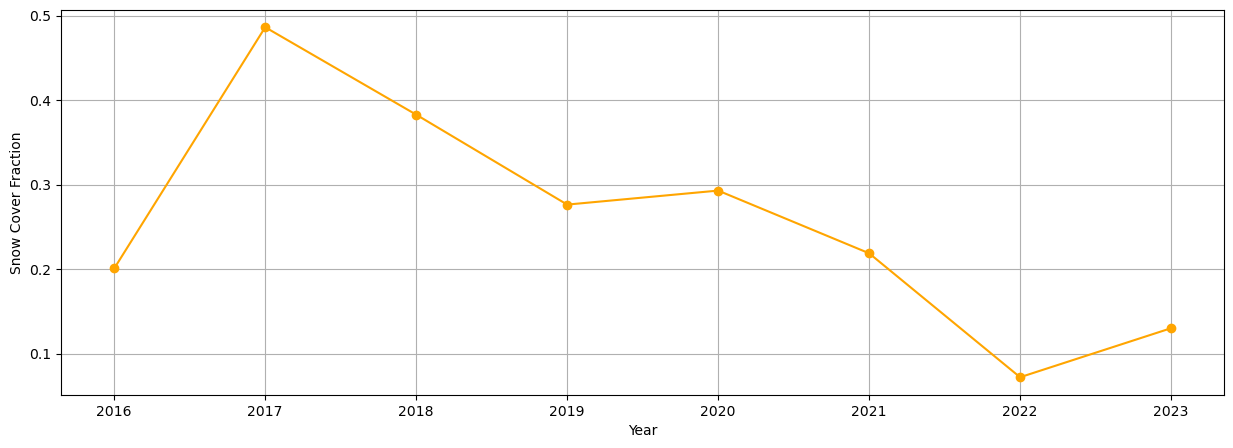

In [8]:
# Extract years and snow cover fractions for plotting
years = list(snow_cover_data.keys())
snow_cover_fractions = [entry['snow_cover_fraction'] for entry in snow_cover_data.values()]

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(years, snow_cover_fractions, color='orange', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Snow Cover Fraction')
plt.grid(True)
plt.show()

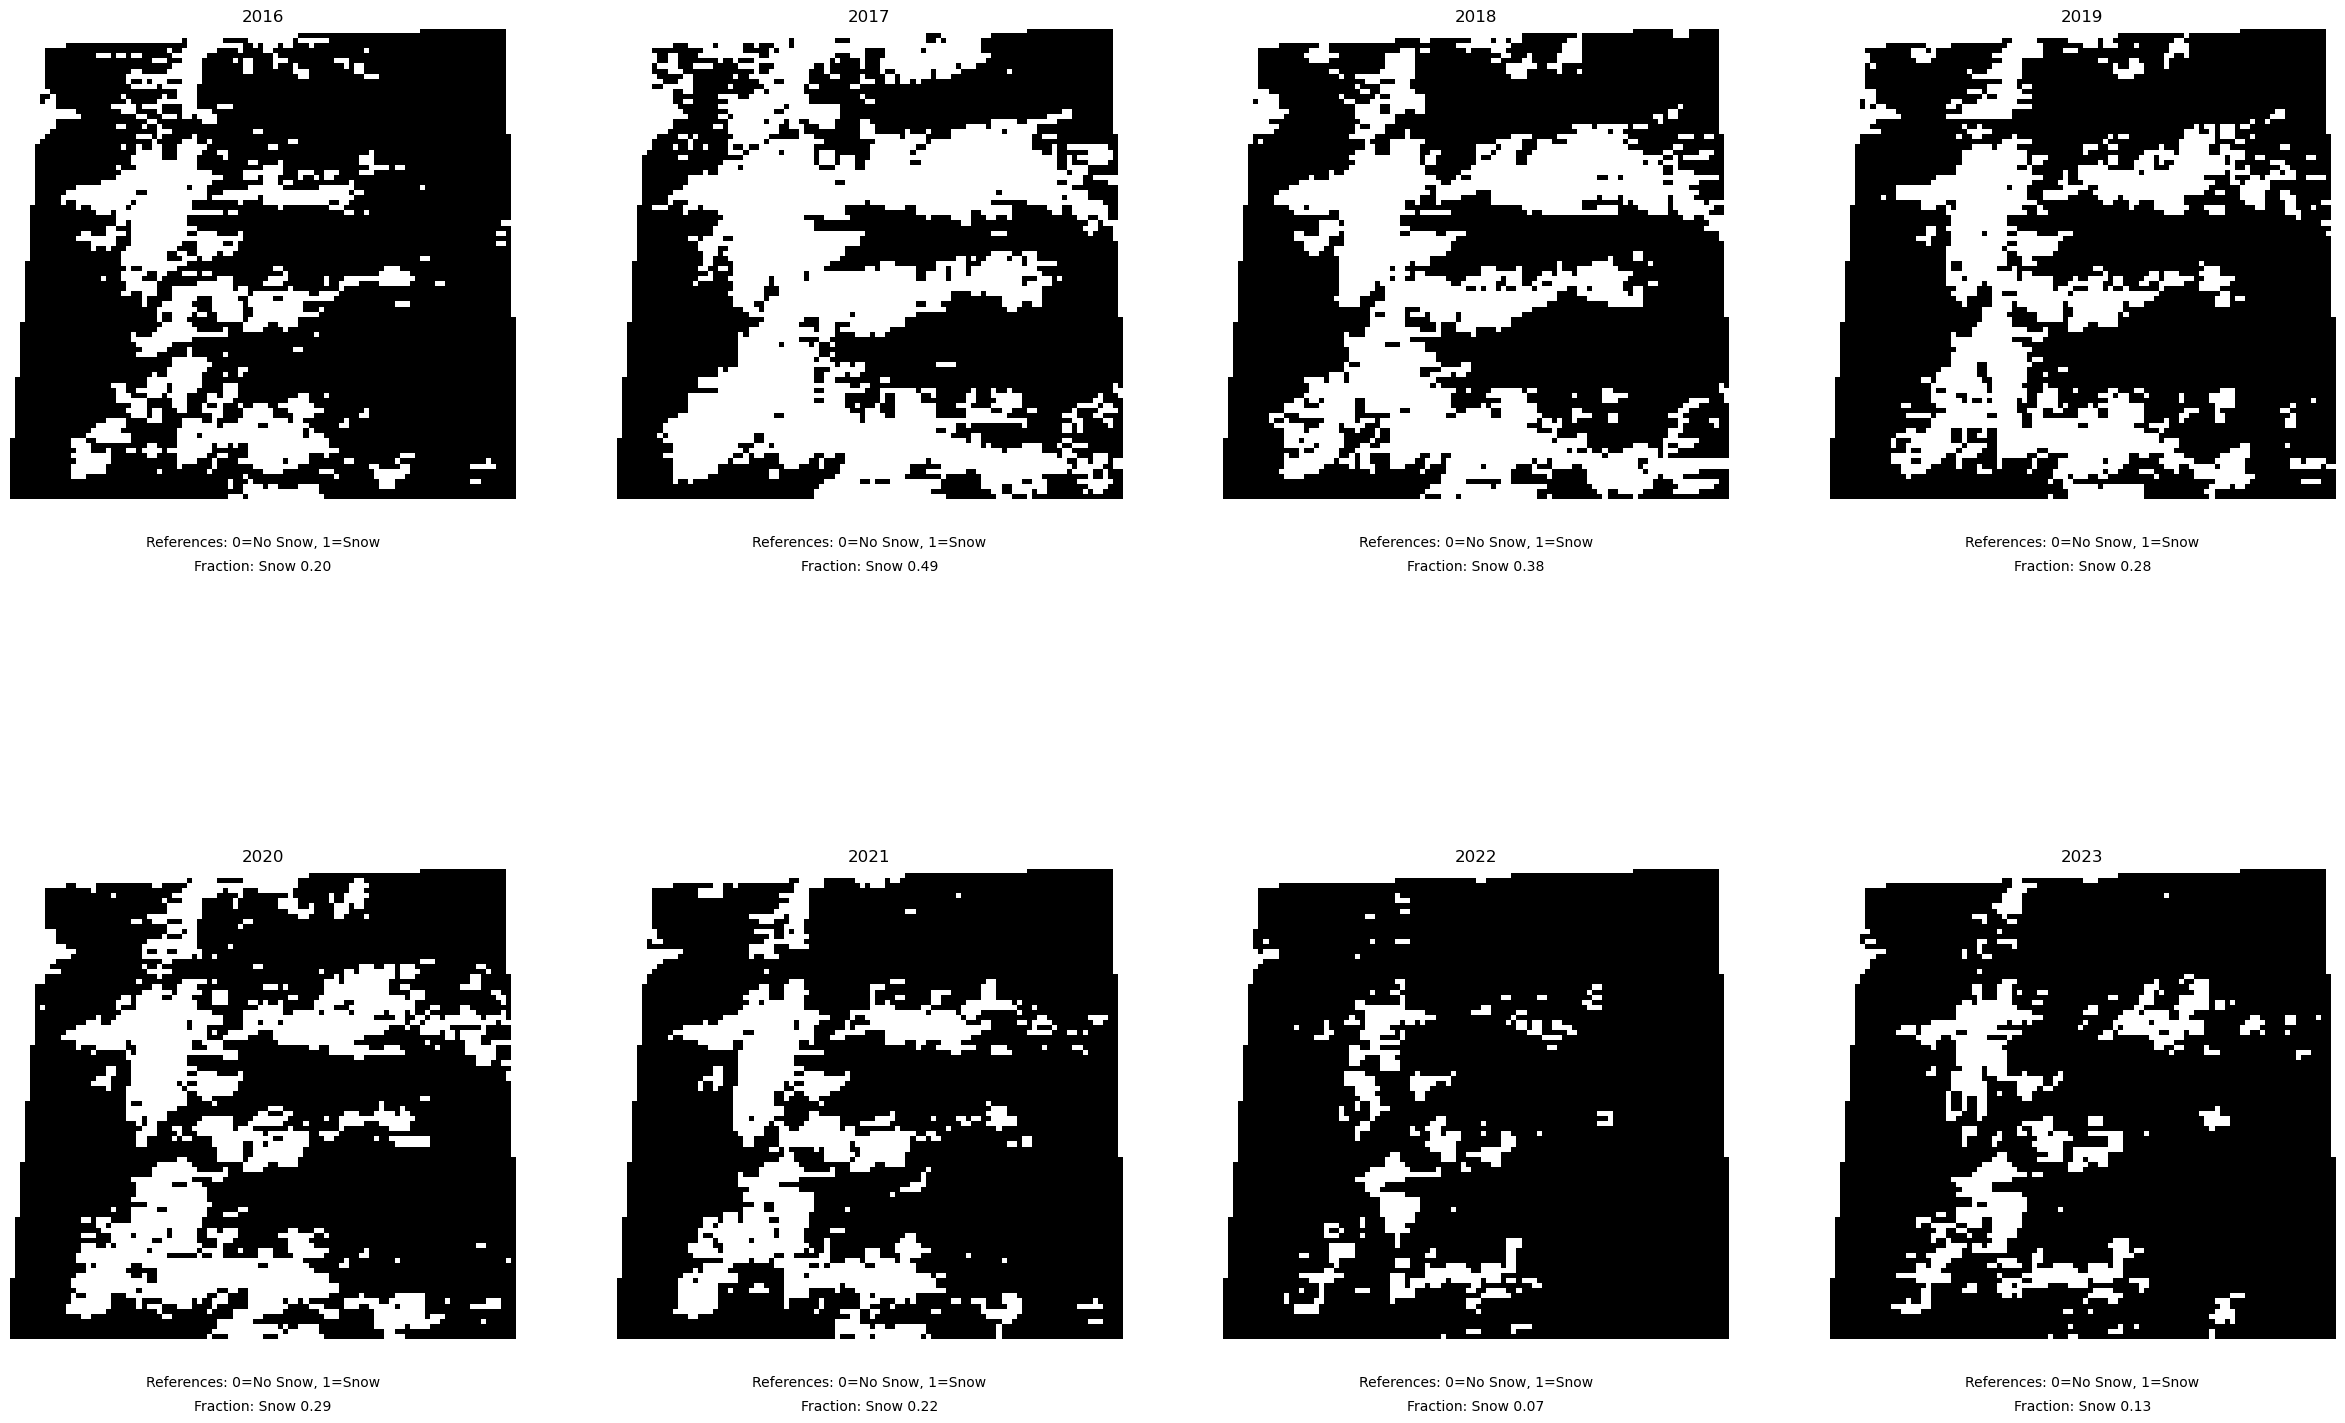

In [9]:
# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = math.ceil(len(years_eval) / num_rows)

# Create a figure and set of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# Iterate over each year
for i, year in enumerate(years_eval):
    # Get the image for the current year
    image = result.filter(ee.Filter.eq('startYear', year)).first()

    # Add Snow Map layer to the map
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    snow_map = ndsi.where(ndsi.lte(0.4), 0).where(ndsi.gt(0.4), 1).rename('snowMap').cast({'snowMap': 'uint8'})

    # Calculate the snow cover fraction
    snow_cover_fraction = snow_map.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=1000,
        maxPixels=1e9
    ).getInfo()['snowMap']
    
    # Get the URL for the image
    url = snow_map.getThumbURL({'region': studyarea_coords, 'min': 0, 'max': 1, 'palette': ['#000000', '#ffffff'], 'dimensions': 100})

    # Get the image from the URL
    image_data = requests.get(url).content
    image = Image.open(BytesIO(image_data))

    # Add the Snow Map to the subplot
    axs[i//num_cols, i%num_cols].imshow(image)
    axs[i//num_cols, i%num_cols].set_title(str(year))
    axs[i//num_cols, i%num_cols].axis('off')

    # Add legend text
    axs[i//num_cols, i%num_cols].text(0.5, -0.1, f'References: 0=No Snow, 1=Snow', size=10, ha="center", transform=axs[i//num_cols, i%num_cols].transAxes)
    axs[i//num_cols, i%num_cols].text(0.5, -0.15, f'Fraction: Snow {snow_cover_fraction:.2f}', size=10, ha="center", transform=axs[i//num_cols, i%num_cols].transAxes)

# Display the subplots
plt.show()

# <center> Intra-annual variation of NDSI (monthly) </center>

In [10]:
# Specify the year for which you want to obtain monthly NDSI
target_year = 2020

In [11]:
# Create a sequence of monthly intervals for the specified year
months_eval = range(1, 13)
monthly_intervals = [(target_year, month) for month in months_eval]

# Function to get the NDSI median for each month
def monthly_ndsi(year, month):
    # Create start and end dates for each month
    date_start = ee.Date.fromYMD(year, month, 1)
    date_end = date_start.advance(1, 'month')

    # Filter Sentinel-2 image collection according to dates, study area, and select bands
    dataset = (ee.ImageCollection('COPERNICUS/S2')
               .filter(ee.Filter.date(date_start, date_end))
               .filterBounds(studyarea)
               .select(['B3', 'B11']))

    # Calculate NDSI for each image in the collection
    def calculate_ndsi(image):
        ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
        return image.addBands(ndsi)

    # Map the NDSI calculation function over the image collection
    ndsi_images = dataset.map(calculate_ndsi)

    # Calculate median NDSI
    median = ndsi_images.median()

    # Clip image to study area
    image_clip = median.clip(studyarea)
    # Add the start year and month property to each image
    image_clip = image_clip.set({'startYear': year, 'startMonth': month})

    # Return image
    return ee.Image(image_clip)

In [12]:
# Map the function to all the entries in the monthly_intervals list
result = list(map(lambda x: monthly_ndsi(*x), monthly_intervals))

# Create an image collection from the list of images generated in the last step
result = ee.ImageCollection.fromImages(result)

In [13]:
# Create a Map
Map = geemap.Map(basemap='HYBRID')

# Snow cover data for each month
snow_cover_data = {}

# Iterate over each monthly interval
for year, month in monthly_intervals:
    # Get the image for the current month
    image = result.filter(ee.Filter.eq('startYear', year).eq('startMonth', month)).first()

    # Add Snow Map layer to the map
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    snow_map = ndsi.where(ndsi.lte(0.4), 0).where(ndsi.gt(0.4), 1).rename('snowMap').cast({'snowMap': 'uint8'})
    Map.addLayer(snow_map, {'min': 0, 'max': 1, 'palette': ['#000000', '#ffffff']}, f'SnowMap_{year}_{month}')
    
    # Calculate snow cover fraction
    snow_cover_fraction = snow_map.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=1000,  # Adjust scale for both visualization and region reduction
        maxPixels=1e9,  # Set maxPixels to a high value
        bestEffort=True
    ).get('snowMap').getInfo()

    # Print information
    print(f'Year: {year}, Month: {month}')
    print(f'Snow Cover Fraction: {snow_cover_fraction}\n')
    
    # Store the result in the dictionary
    snow_cover_data[(year, month)] = snow_cover_fraction

# Center the map on the study area
Map.centerObject(studyarea, 9)

# Display the map
Map


Year: 2020, Month: 1
Snow Cover Fraction: 0.0542690560503631

Year: 2020, Month: 2
Snow Cover Fraction: 0.08518796723539729

Year: 2020, Month: 3
Snow Cover Fraction: 0.06751797403154851

Year: 2020, Month: 4
Snow Cover Fraction: 0.17567335551024799

Year: 2020, Month: 5
Snow Cover Fraction: 0.16118324569875178

Year: 2020, Month: 6
Snow Cover Fraction: 0.9203526844797373

Year: 2020, Month: 7
Snow Cover Fraction: 0.9462674822048148

Year: 2020, Month: 8
Snow Cover Fraction: 0.916865185821083

Year: 2020, Month: 9
Snow Cover Fraction: 0.6684622813606614

Year: 2020, Month: 10
Snow Cover Fraction: 0.4303394498694426

Year: 2020, Month: 11
Snow Cover Fraction: 0.18745931251564915

Year: 2020, Month: 12
Snow Cover Fraction: 0.09360088707658197



Map(center=[-49.880441648717714, -72.9416050522184], controls=(WidgetControl(options=['position', 'transparent…

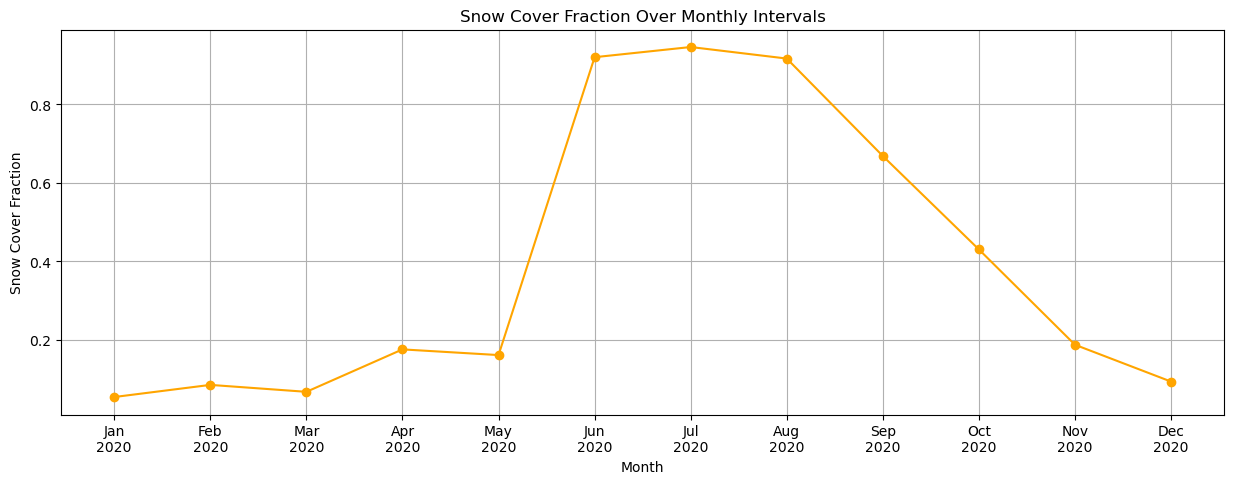

In [14]:
# Extract years and months and snow cover fractions for plotting
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year_month_keys = snow_cover_data.keys()
snow_cover_fractions = [snow_cover_data[key] for key in year_month_keys]

# Plotting the data using plt.plot_date()
plt.figure(figsize=(15, 5))
plt.plot(range(len(year_month_keys)), snow_cover_fractions, color='orange', marker='o', linestyle='-')
plt.title('Snow Cover Fraction Over Monthly Intervals')
plt.xlabel('Month')
plt.ylabel('Snow Cover Fraction')
plt.grid(True)  # Add grid to the plot

# Print months
plt.xticks(range(len(year_month_keys)), [f'{months[month-1]}\n{year}' for year, month in year_month_keys])

plt.show()



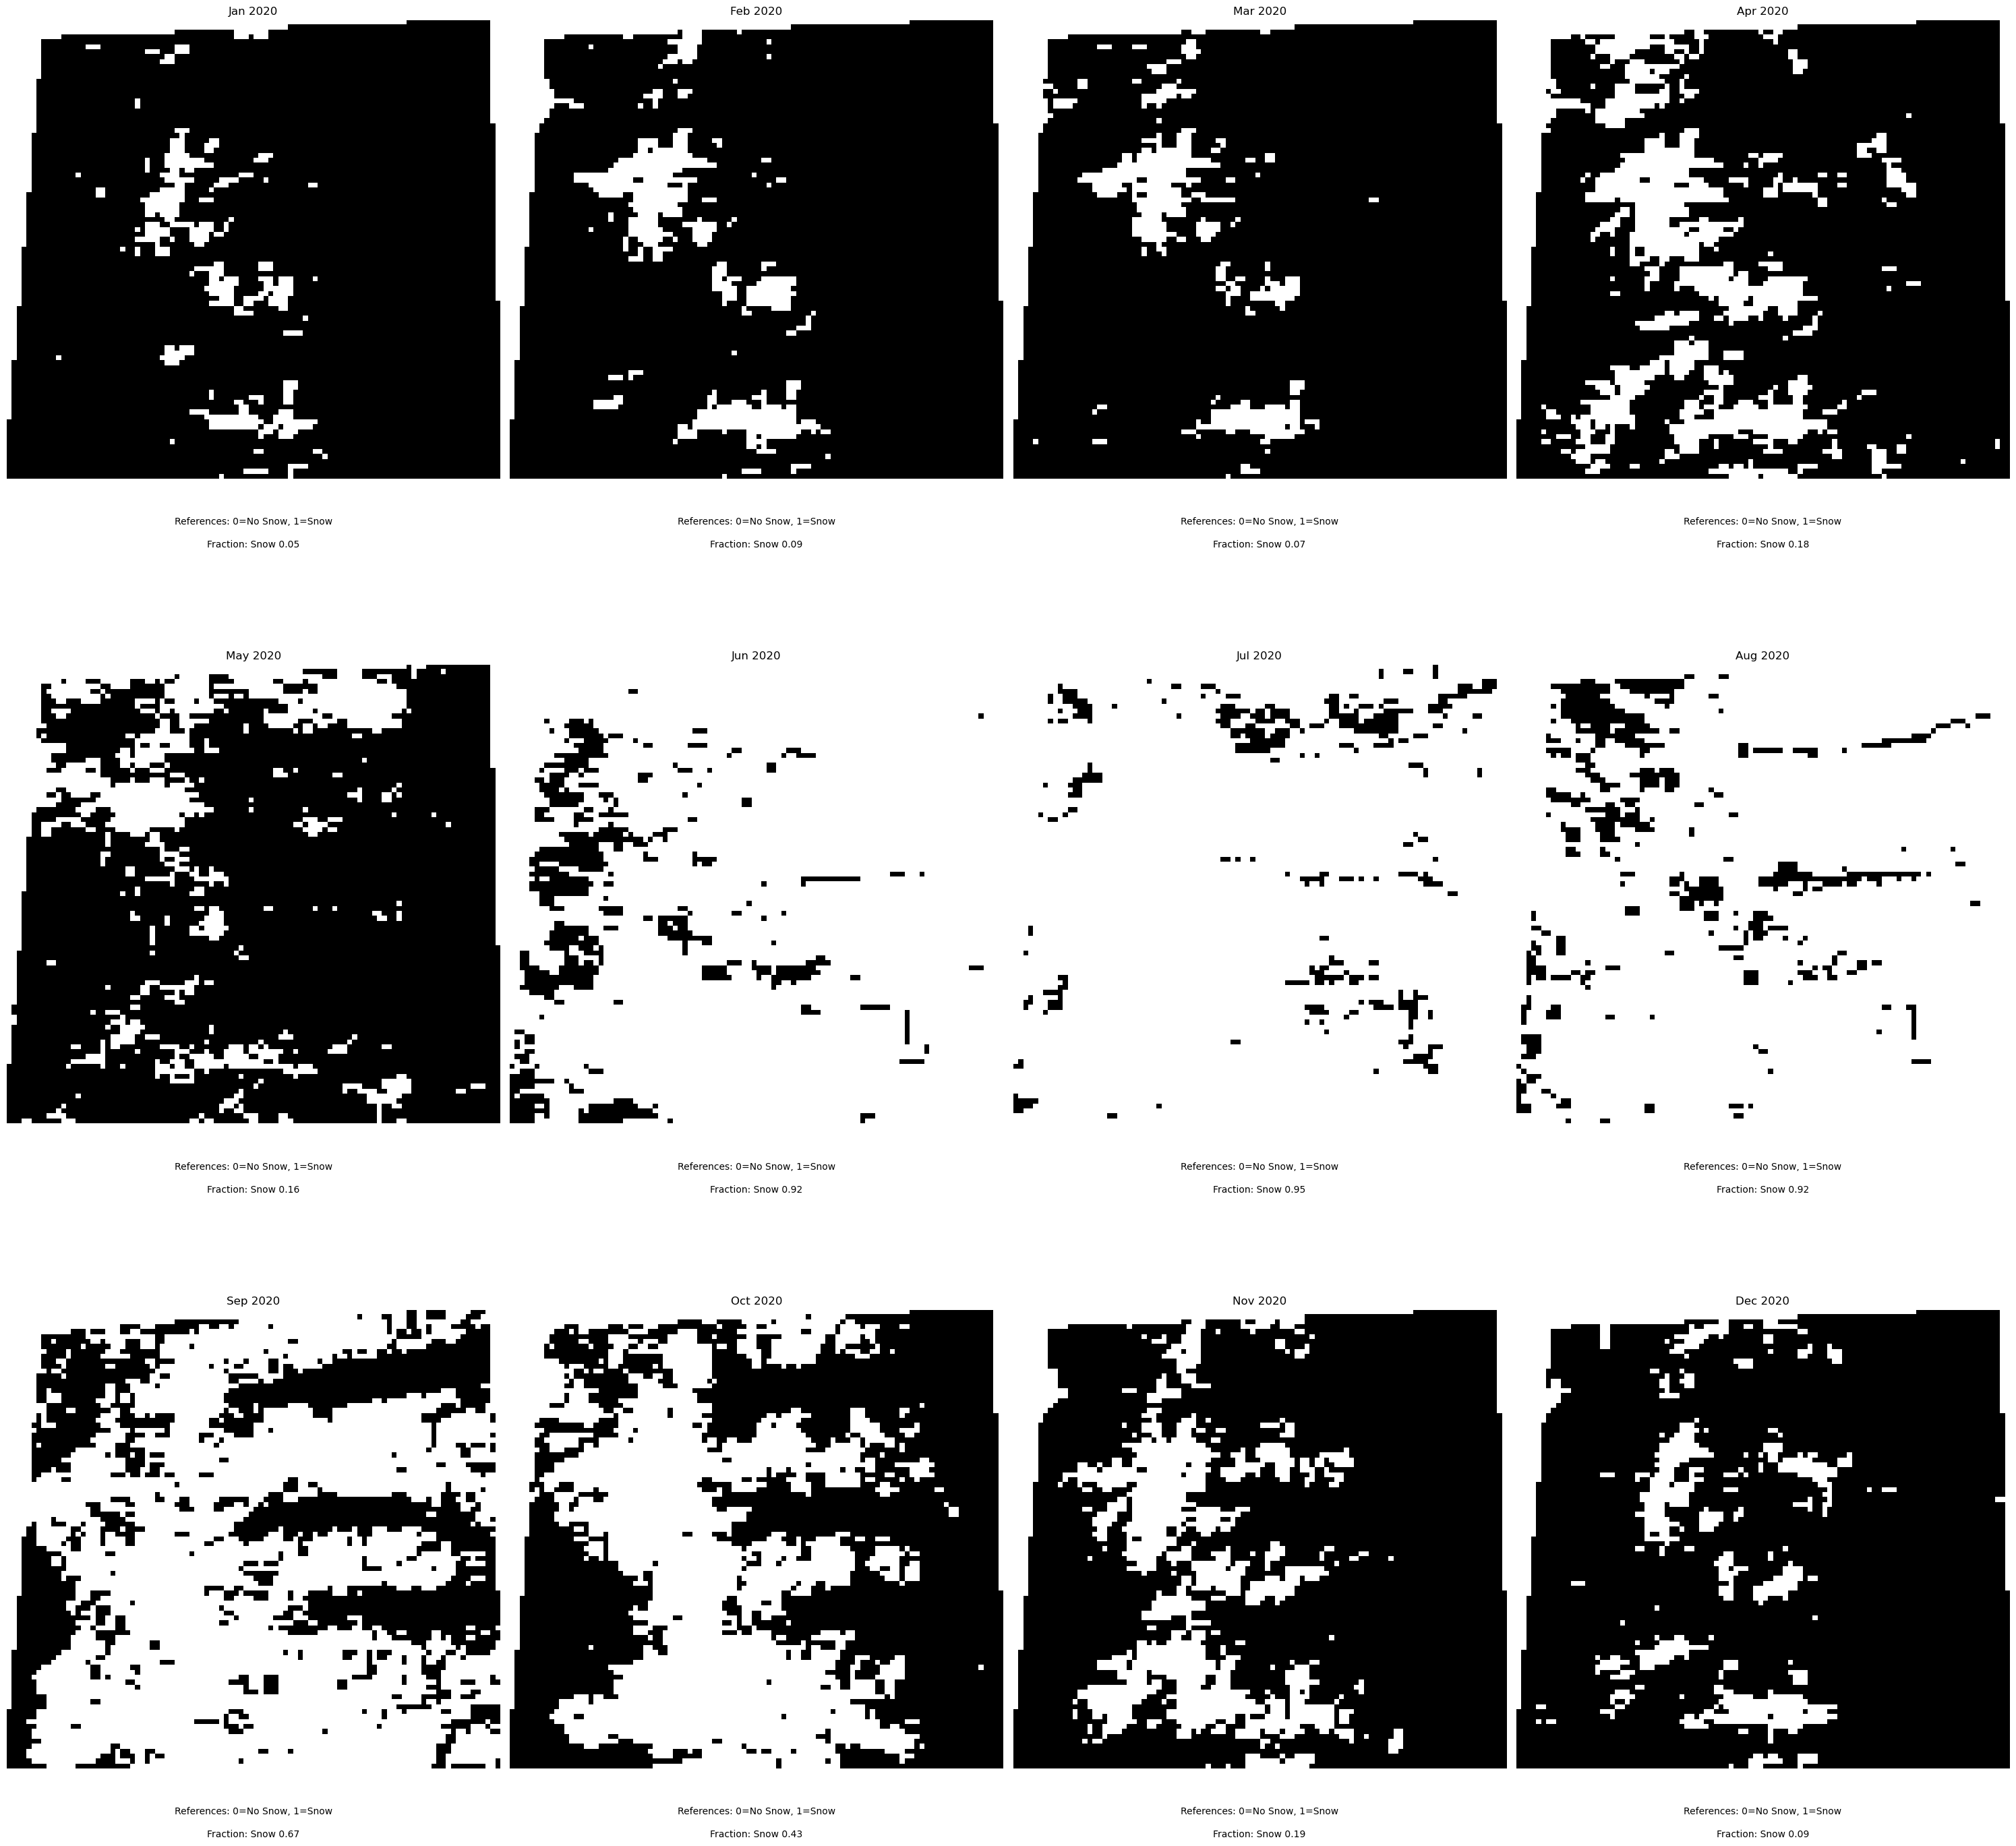

In [15]:
# Calculate the number of rows and columns for subplots
num_rows = 3
num_cols = math.ceil(len(year_month_keys) / num_rows)

# Create a figure and set of subplots
fig = plt.figure(figsize=(30, 30))
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1]*num_cols, height_ratios=[1]*num_rows)

# Iterate over each year and month
for i, (year, month) in enumerate(year_month_keys):
    year = int(year)
    month = int(month)

    # Get the image for the current year and month
    image = result.filter(ee.Filter.eq('startYear', year)).filter(ee.Filter.eq('startMonth', month)).first()

    # Add Snow Map layer to the map
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    snow_map = ndsi.where(ndsi.lte(0.4), 0).where(ndsi.gt(0.4), 1).rename('snowMap').cast({'snowMap': 'uint8'})

    # Calculate the snow cover fraction
    snow_cover_fraction = snow_map.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=1000,
        maxPixels=1e9
    ).getInfo()['snowMap']
    
    # Get the URL for the image
    url = snow_map.getThumbURL({'region': studyarea_coords, 'min': 0, 'max': 1, 'palette': ['#000000', '#ffffff'], 'dimensions': 100})

    # Get the image from the URL
    image_data = requests.get(url).content
    image = Image.open(BytesIO(image_data))

    # Add the Snow Map to the subplot using gridspec
    ax = plt.subplot(gs[i//num_cols, i%num_cols])
    ax.imshow(image)
    ax.set_title(f'{calendar.month_abbr[month]} {year}')
    ax.axis('off')

    # Add legend text
    ax.text(0.5, -0.1, f'References: 0=No Snow, 1=Snow', size=10, ha="center", transform=ax.transAxes)
    ax.text(0.5, -0.15, f'Fraction: Snow {snow_cover_fraction:.2f}', size=10, ha="center", transform=ax.transAxes)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the subplots
plt.show()
